# Gaussian Mixture Model (GMM) for Predicting Three Gaussian Distributions    

  
In this experiment, we are using a Gaussian Mixture Model (GMM) to predict the presence of three Gaussian distributions. A GMM is a probabilistic model that assumes the data is generated from a mixture of Gaussian distributions. 
    
The GMM model is trained on a dataset that contains samples from the three Gaussian distributions. The model learns the parameters of the Gaussian distributions, including the mean and covariance, as well as the mixing coefficients that determine the contribution of each Gaussian distribution to the overall mixture.
    
Once the GMM model is trained, it can be used to predict the presence of the three Gaussian distributions in new data. The model assigns a probability to each data point indicating the likelihood that it belongs to each Gaussian distribution. The predicted distribution for each data point is determined by selecting the Gaussian distribution with the highest probability.
    
By using a GMM model, we can effectively capture the complex patterns and relationships present in the data, allowing us to make accurate predictions about the underlying Gaussian distributions. This approach is particularly useful in scenarios where the data is not easily separable or follows a non-linear pattern.
    
Overall, the GMM model provides a powerful tool for predicting the presence of multiple Gaussian distributions and can be applied to a wide range of applications, including clustering, anomaly detection, and generative modeling.

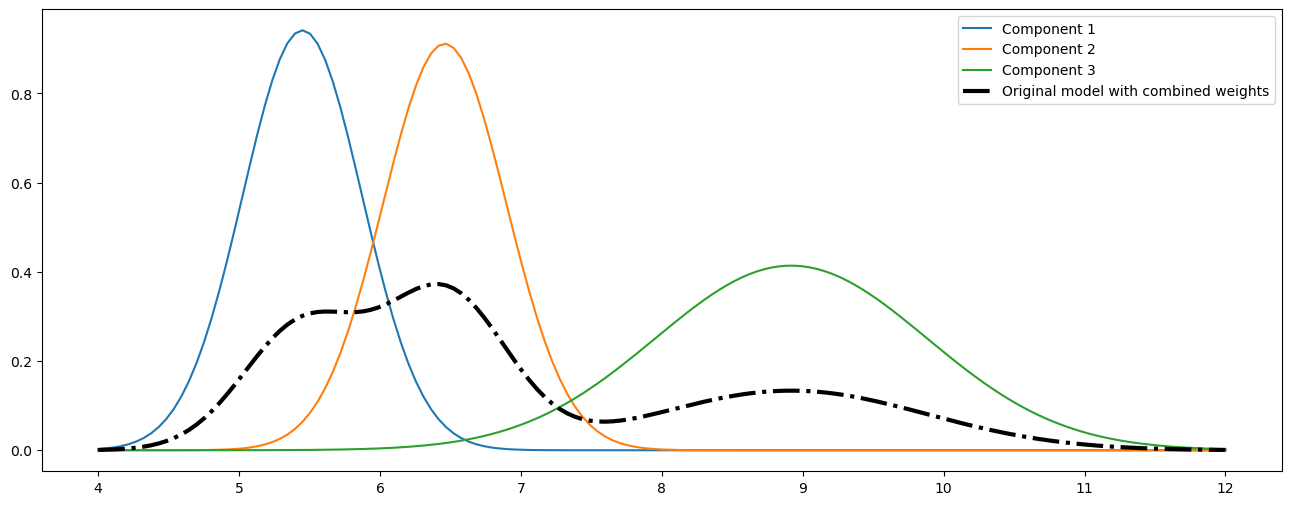

In [65]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
np.random.seed(0)

num_dist = 3
# Generate random weights
weights = [np.random.uniform(0, 1) for _ in range(num_dist)]
# Normalize the weights and mu
weights /= np.sum(weights)
mu_sig = np.array([np.random.uniform(0, 10) for _ in range(num_dist*2)])

v = .1
mu_sig = mu_sig.reshape(num_dist, 2)
# Generate the mixture model
generative_m = np.array([stats.norm(i[0], i[1]*v) for i in mu_sig])
func = lambda x: sum([w * g.pdf(x) for w, g in zip(weights, generative_m)])

elements = [i for i in range(num_dist)]
draw = np.random.choice(elements,size = 1000,  p=weights)

x_i = np.array([g.rvs() for g in generative_m[draw]])

# plot generated data and the latent distributions
x = np.linspace(4, 12, 150)
plt.figure(figsize=(16, 6))
for i in range(num_dist):
    plt.plot(x, generative_m[i].pdf(x), label=f'Component {i+1}')
plt.plot(x, func(x), lw=3, ls='-.', color='black', label='Original model with combined weights')
plt.legend()


In [ ]:
class EM:
    def __init__(self, k):
        self.k = k
        self.mu = None
        self.std = np.ones(k)
        self.w_ij = None
        self.phi = np.ones(k) / k

    def expectation_step(self, x):
        for z_i in range(self.k):
            self.w_ij[z_i] = stats.norm(self.mu[z_i], self.std[z_i]).pdf(x) * self.phi[z_i]
	# normalize zo that marginalizing z would lead to p = 1
	
        # Fix ?
        self.w_ij /= self.w_ij.sum(0)

    def maximization_step(self, x):
        self.phi = self.w_ij.mean(1)
        self.std = ((self.w_ij * (x - self.mu[:, None])**2).sum(1) / self.w_ij.sum(1))**0.5
        self.mu = (self.w_ij * x).sum(1) / self.w_ij.sum(1)

    def fit(self, x):
        self.mu = np.random.uniform(x.min(), x.max(), size=self.k)
        self.w_ij = np.zeros((self.k, x.shape[0]))

        last_mu = np.ones(self.k) * np.inf
        i = 0
        while ~np.all(np.isclose(self.mu, last_mu)):
            last_mu = self.mu
            # print(self.mu)
            print(f'Iteration {i}')
            self.expectation_step(x)
            self.maximization_step(x)
            i+=1

k = 3
m = EM(k)

m.fit(x_i)

In [ ]:
print(f'phi: {m.phi}, mu: {m.mu}, std: {m.std}')


def plot_all(x=x, k=k, m=m, generative_m=generative_m, with_weights=False):
    fitted_m = [stats.norm(mu, std) for mu, std in zip(m.mu, m.std)]
    plt.figure(figsize=(16, 6))
    if with_weights:
        for i in range(k):
            plt.plot(x, m.phi[i]*fitted_m[i].pdf(x), label=f'Predictited Distribution {i}', lw=3)
    else:
        for i in range(k):
            plt.plot(x, fitted_m[i].pdf(x), label=f'Predictited Distribution {i}', lw=3)

    for i in range(num_dist):
        plt.plot(x, generative_m[i].pdf(x), label=f'Component {i+1}', ls='--')
    plt.plot(x, func(x), lw=3, ls='-.', color='black', label='Original model with combined weights')
    plt.plot(x, np.array([m.phi[i]*fitted_m[i].pdf(x) for i in range(k)]).sum(0), lw=3, ls='-.', color='red', label='Mixture model with combined weights')
    plt.legend()
    
plot_all(with_weights=True)

## Variational Inference with nonlinear programming

In [68]:
#!/usr/bin/env python3
# @author: R. Gowers, S. Al-Izzi, T. Pollington, R. Hill & K. Briggs

import cvxpy as cp
import numpy as np
import math
from scipy.special import xlogy

def channel_capacity(n, m, P, sum_x=1):
    '''
    Boyd and Vandenberghe, Convex Optimization, exercise 4.57 page 207
    Capacity of a communication channel.

    We consider a communication channel, with input X(t)∈{1,..,n} and
    output Y(t)∈{1,...,m}, for t=1,2,... .The relation between the
    input and output is given statistically:
    p_(i,j) = ℙ(Y(t)=i|X(t)=j), i=1,..,m  j=1,...,n

    The matrix P ∈ ℝ^(m*n) is called the channel transition matrix, and
    the channel is called a discrete memoryless channel. Assuming X has a
    probability distribution denoted x ∈ ℝ^n, i.e.,
    x_j = ℙ(X=j), j=1,...,n

    The mutual information between X and Y is given by
    ∑(∑(x_j p_(i,j)log_2(p_(i,j)/∑(x_k p_(i,k)))))
    Then channel capacity C is given by
    C = sup I(X;Y).
    With a variable change of y = Px this becomes
    I(X;Y)=  c^T x - ∑(y_i log_2 y_i)
    where c_j = ∑(p_(i,j)log_2(p_(i,j)))
    '''

    # n is the number of different input values
    # m is the number of different output values
    if n*m == 0:
        print('The range of both input and output values must be greater than zero')
        return 'failed', np.nan, np.nan

    # x is probability distribution of the input signal X(t)
    x = cp.Variable(shape=n)

    # y is the probability distribution of the output signal Y(t)
    # P is the channel transition matrix
    y = P@x
    # I is the mutual information between x and y
    c = np.sum(np.array((xlogy(P, P) )), axis=0)
    I = c@x + cp.sum(cp.entr(y) )
    
    # # for multiple dimensions - not tested
    # if x.shape[1]==1:
    #     y = P@x
    #     # I is the mutual information between x and y
    #     c = np.sum(np.array((xlogy(P, P) )), axis=0)
    #     I = c@x + cp.sum(cp.entr(y) )
    # else:
    #     y = []
    #     c = np.sum(np.array((xlogy(P, P) )), axis=0)
    #     I = 0
    #     for i in range(x.shape[1]):
    #         y[i]=P@x[i]
    #         I += c@x[i] + cp.sum(cp.entr(y[i]) )
            

    # I = c@x + cp.sum(cp.entr(y) )
    # Channel capacity maximised by maximising the mutual information
    obj = cp.Maximize(I)
    constraints = [cp.sum(x) == sum_x,x >= 0]

    # Form and solve problem
    prob = cp.Problem(obj,constraints)
    prob.solve(solver=cp.ECOS)
    # prob.solve()
    if prob.status=='optimal':
        return prob.status, prob.value, x.value
    else:
        return prob.status, np.nan, np.nan

In [69]:
class my_EM:
    def __init__(self, k):
        self.k = k
        self.mu = None
        self.std = np.ones(k)
        self.w_ij = None
        self.phi = np.ones(k) / k

    def expectation_step(self, x):
        for z_i in range(self.k):
            self.w_ij[z_i] = stats.norm(self.mu[z_i], self.std[z_i]).pdf(x) * self.phi[z_i]
	# normalize zo that marginalizing z would lead to p = 1
	
        self.w_ij /= self.w_ij.sum(0)

    def maximization_step(self, x):
        # self.phi = self.w_ij.mean(1)
        P = np.array([stats.norm(self.mu[z_i], self.std[z_i]).pdf(x) for z_i in range(self.k)]).T
    
        stat, C, _phi = channel_capacity(self.k, len(x), P)
        self.phi = _phi
        print('Optimal value of C = {:.4g}'.format(C))
        print('Optimal variable phi = \n', self.phi)
        
        self.std = ((self.w_ij * (x - self.mu[:, None])**2).sum(1) / self.w_ij.sum(1))**0.5
        self.mu = (self.w_ij * x).sum(1) / self.w_ij.sum(1)

    def fit(self, x):
        
        self.mu = np.random.uniform(x.min(), x.max(), size=self.k)
        self.w_ij = np.zeros((self.k, x.shape[0]))

        last_mu = np.ones(self.k) * np.inf
        i = 0
        while ~np.all(np.isclose(self.mu, last_mu)):
            print(f'iteration: {i}')
            last_mu = self.mu
            self.expectation_step(x)
            self.maximization_step(x)
            i+=1

k = 3
m1 = my_EM(k)
m1.fit(x_i)

iteration: 0
Optimal value of C = 103.5
Optimal variable phi = 
 [0.29650056 0.38637878 0.31712067]
iteration: 1


/home/jack/.local/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:354: FutureWarning: 
    You specified your problem should be solved by ECOS. Starting in
    CXVPY 1.6.0, ECOS will no longer be installed by default with CVXPY.
    Please either add an explicit dependency on ECOS or switch to our new
    default solver, Clarabel, by either not specifying a solver argument
    or specifying ``solver=cp.CLARABEL``.
    
  warnings.warn(ECOS_DEP_DEPRECATION_MSG, FutureWarning)


Optimal value of C = 104.7
Optimal variable phi = 
 [0.11554553 0.44203957 0.4424149 ]
iteration: 2
Optimal value of C = 98.79
Optimal variable phi = 
 [-3.86760542e-10  4.56901451e-01  5.43098550e-01]
iteration: 3
Optimal value of C = 91.56
Optimal variable phi = 
 [-2.18381992e-10  4.64141731e-01  5.35858269e-01]
iteration: 4
Optimal value of C = 83.43
Optimal variable phi = 
 [-2.94318963e-10  4.71921185e-01  5.28078815e-01]
iteration: 5
Optimal value of C = 76.78
Optimal variable phi = 
 [-1.88832915e-10  4.78508398e-01  5.21491602e-01]
iteration: 6
Optimal value of C = 72.45
Optimal variable phi = 
 [-8.44840531e-11  4.82888843e-01  5.17111157e-01]
iteration: 7
Optimal value of C = 69.94
Optimal variable phi = 
 [-1.39128949e-10  4.85440736e-01  5.14559264e-01]
iteration: 8
Optimal value of C = 68.56
Optimal variable phi = 
 [-2.39018235e-10  4.86829987e-01  5.13170013e-01]
iteration: 9
Optimal value of C = 67.82
Optimal variable phi = 
 [-2.34848666e-10  4.87565304e-01  5.1243469

phi: [0.30739632 0.30970717 0.38289651], mu: [6.49226397 5.48067441 8.79821483], std: [0.38949533 0.43832341 1.00544969]


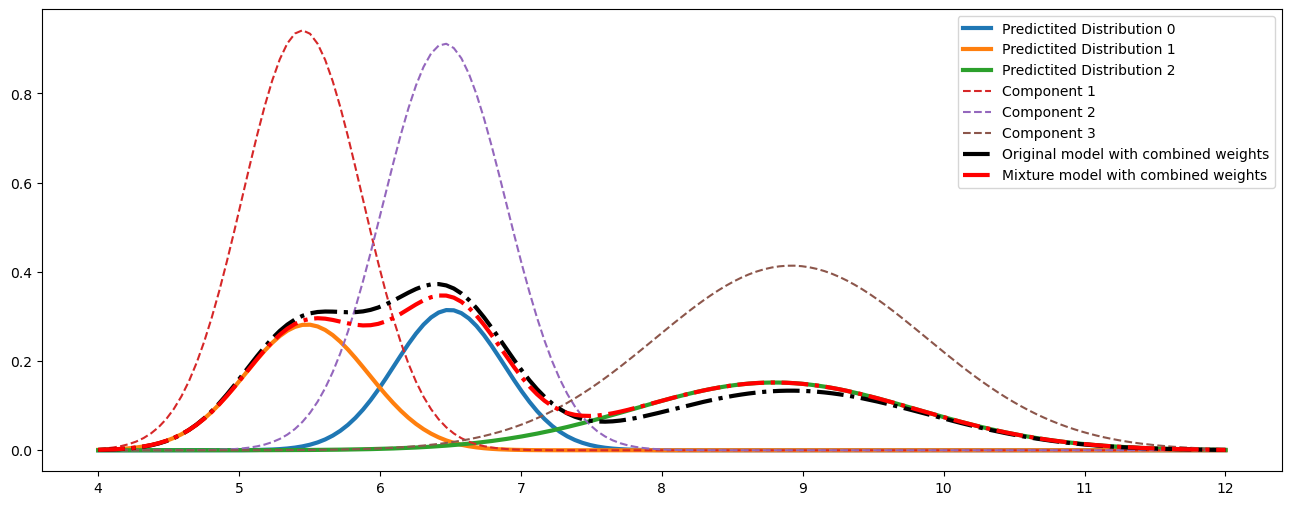

In [70]:
print(f'phi: {m1.phi}, mu: {m1.mu}, std: {m1.std}')
plot_all(m=m1, k =k, with_weights=True)


## Use sklearn package

In [ ]:
from sklearn.mixture import GaussianMixture

x1 = x_i.reshape(-1,1)
# first of all, let's confirm the optimal number of components
bics = []
min_bic = 0
counter=1
for i in range (10): # test the AIC/BIC metric between 1 and 10 components
  gmm = GaussianMixture(n_components = counter, max_iter=1000, random_state=0, covariance_type = 'full')
  labels = gmm.fit(x1).predict(x1)
  bic = gmm.bic(x1)
  bics.append(bic)
  if bic < min_bic or min_bic == 0:
    min_bic = bic
    opt_bic = counter
  counter = counter + 1


# plot the evolution of BIC/AIC with the number of components
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1,2,1)
# Plot 1
plt.plot(np.arange(1,11), bics, 'o-', lw=3, c='black', label='BIC')
plt.legend(frameon=False, fontsize=15)
plt.xlabel('Number of components', fontsize=20)
plt.ylabel('Information criterion', fontsize=20)
plt.xticks(np.arange(0,11, 2))
plt.title('Opt. components = '+str(opt_bic), fontsize=20)


# Since the optimal value is n=2 according to both BIC and AIC, let's write down:
n_optimal = opt_bic

# create GMM model object
gmm = GaussianMixture(n_components = n_optimal, max_iter=1000, random_state=10, covariance_type = 'full')

# find useful parameters
g_mean = gmm.fit(x1).means_  
g_covs  = gmm.fit(x1).covariances_
g_weights = gmm.fit(x1).weights_

# create necessary things to plot
x_axis = np.arange(-10, 15, 0.1)
# y_axis0 = stats.norm.pdf(x_axis, float(mean[0][0]), np.sqrt(float(covs[0][0][0])))*weights[0] # 1st gaussian
# y_axis1 = stats.norm.pdf(x_axis, float(mean[1][0]), np.sqrt(float(covs[1][0][0])))*weights[1] # 2nd gaussian

ax = fig.add_subplot(1,2,2)
# Plot 2
# plt.hist(x, density=True, bins=1000, histtype='bar', ec='red', alpha=0.5)
for i in range(n_optimal):
  y_axis = stats.norm.pdf(x_axis, float(g_mean[i]), np.sqrt(float(g_covs[i][0][0])))*g_weights[i]
  ax.plot(x_axis, y_axis, lw=3, label='Component '+str(i+1))
plt.plot(x, func(x), lw=3, ls='-.', color='black', label='Original model with combined weights')
plt.xlim(2, 12)
#plt.ylim(0.0, 2.0)
plt.xlabel(r"X", fontsize=20)
plt.ylabel(r"Density", fontsize=20)
plt.legend()

plt.subplots_adjust(wspace=0.3)

## 2D experiments

In [74]:
from sklearn.datasets import make_spd_matrix
np.random.seed(0)
# define the number of samples to be drawn
n_samples = 100
# define the mean points for each of the systhetic cluster centers
t_means = [[8.4, 8.2], [1.4, 1.6], [2.4, 5.4], [6.4, 2.4]]
# define the number of clusters to be learned
k = 6

# for each cluster center, create a Positive semidefinite convariance matrix
t_covs = []
for s in range(len(t_means)):
  t_covs.append(make_spd_matrix(2))

X = []
for mean, cov in zip(t_means,t_covs):
  x = np.random.multivariate_normal(mean, cov, n_samples)
  X += list(x)
  
X = np.array(X)
np.random.shuffle(X)
print("Dataset shape:", X.shape)
# Create a grid for visualization purposes 
x = np.linspace(np.min(X[...,0])-1,np.max(X[...,0])+1,100)
y = np.linspace(np.min(X[...,1])-1,np.max(X[...,1])+1,80)
X_,Y_ = np.meshgrid(x,y)
pos = np.array([X_.flatten(),Y_.flatten()]).T
print(pos.shape)
print(np.max(pos[...,1]))

# create and initialize the cluster centers and the weight paramters
weights = np.ones((k)) / k
means = np.random.choice(X.flatten(), (k,X.shape[1]))
print(means)
print(weights)
# create and initialize a Positive semidefinite convariance matrix 
cov = []
for i in range(k):
  cov.append(make_spd_matrix(X.shape[1]))
  
cov = np.array(cov)
print(cov.shape)

Dataset shape: (400, 2)
(8000, 2)
10.603064122240198
[[8.50225376 5.18307425]
 [6.50756745 6.45989619]
 [6.45989619 6.578757  ]
 [8.09576532 1.21822417]
 [2.80724067 9.68912177]
 [3.72773771 4.99491678]]
[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
(6, 2, 2)


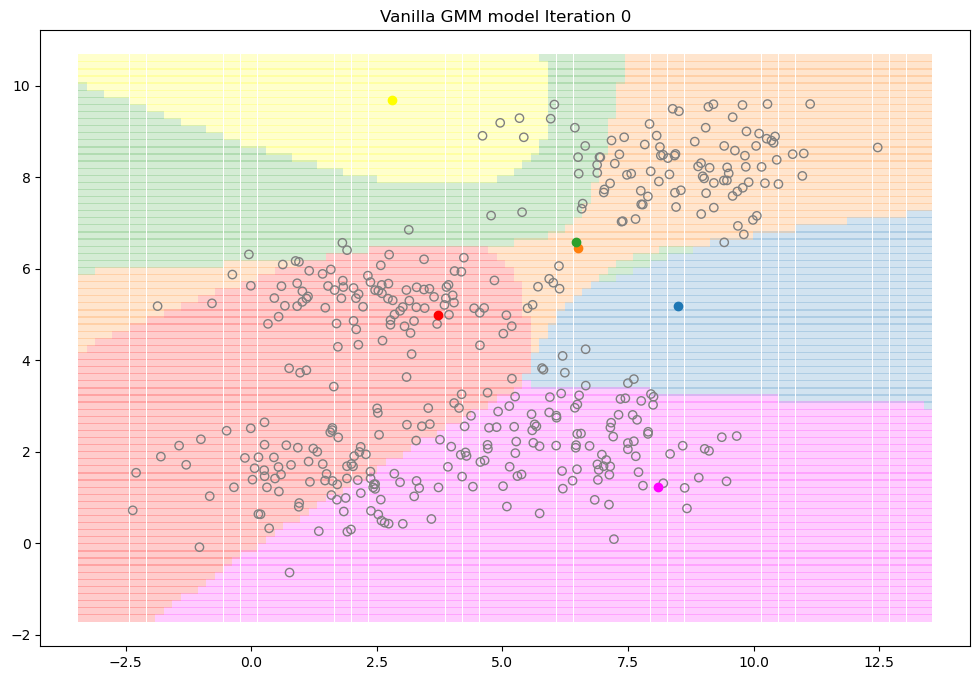

weights: [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667],
 means:
 [[8.50225376 5.18307425]
 [6.50756745 6.45989619]
 [6.45989619 6.578757  ]
 [8.09576532 1.21822417]
 [2.80724067 9.68912177]
 [3.72773771 4.99491678]],
 cov:
 [[[ 2.62304906 -0.38769366]
  [-0.38769366  0.76484311]]

 [[ 2.49468186  0.6049144 ]
  [ 0.6049144   0.90198392]]

 [[ 2.69691212 -0.53997528]
  [-0.53997528  0.99959095]]

 [[ 2.82537648  0.27230685]
  [ 0.27230685  0.89353577]]

 [[ 1.75651873 -0.9332685 ]
  [-0.9332685   0.97946575]]

 [[ 1.8486308   0.92739823]
  [ 0.92739823  1.09824145]]]


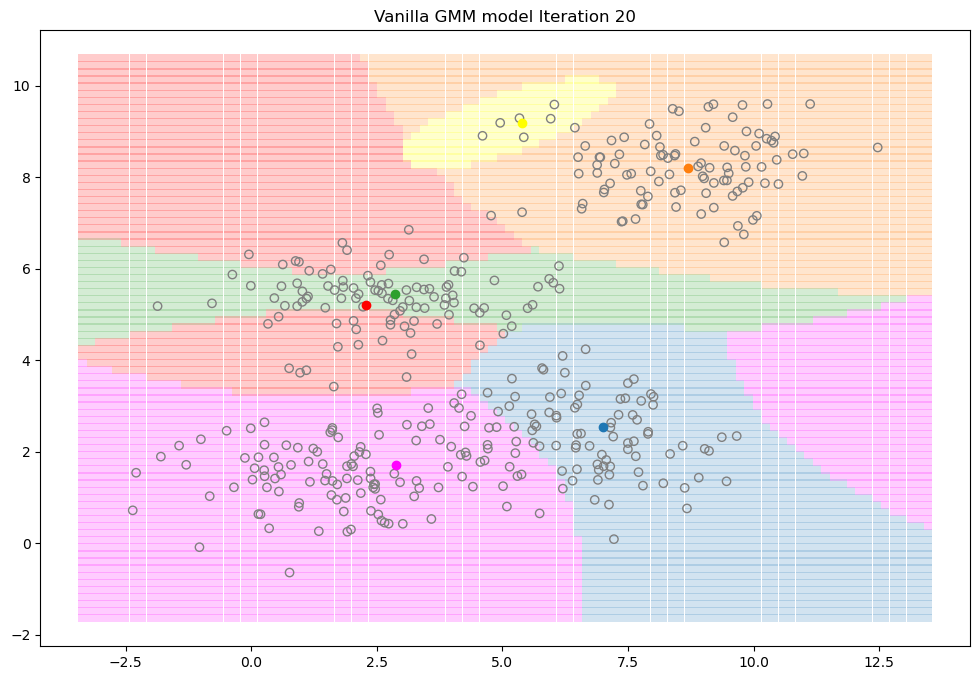

weights: [0.14329496 0.23542527 0.1390937  0.35864122 0.01425098 0.10669357],
 means:
 [[7.00955626 2.53363554]
 [8.69154182 8.20401224]
 [2.85501041 5.45247351]
 [2.89247928 1.71246749]
 [5.38420616 9.19511041]
 [2.29369078 5.2008252 ]],
 cov:
 [[[ 1.35663099 -0.52929065]
  [-0.52929065  0.88624772]]

 [[ 1.94239916  0.2038914 ]
  [ 0.2038914   0.50654451]]

 [[ 3.20682672 -0.01612242]
  [-0.01612242  0.1305658 ]]

 [[ 5.87947632  0.56029627]
  [ 0.56029627  0.61597325]]

 [[ 0.26940278  0.08652232]
  [ 0.08652232  0.05811621]]

 [[ 1.62567492 -0.00628215]
  [-0.00628215  0.71504304]]]


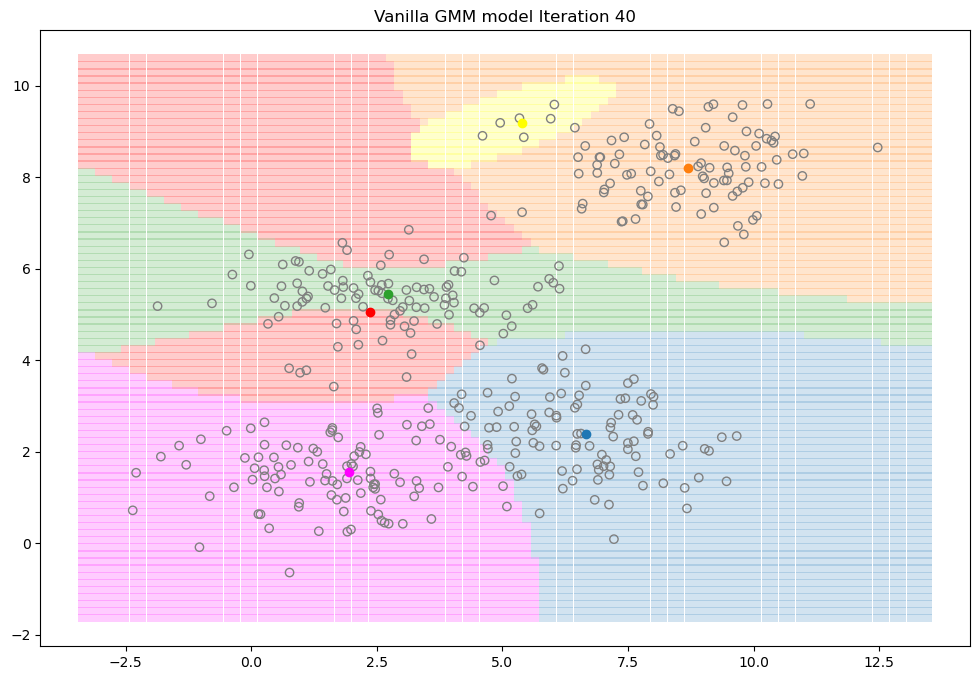

weights: [0.22600093 0.23518203 0.17764191 0.27562367 0.01425228 0.07073296],
 means:
 [[6.65996234 2.39174842]
 [8.69562822 8.20494832]
 [2.73289811 5.45226061]
 [1.95675469 1.56473695]
 [5.38404283 9.1950945 ]
 [2.36284078 5.06243008]],
 cov:
 [[[ 1.81899874 -0.32196209]
  [-0.32196209  0.72917255]]

 [[ 1.92835479  0.20022057]
  [ 0.20022057  0.50635627]]

 [[ 3.13417382 -0.10255937]
  [-0.10255937  0.18036186]]

 [[ 3.22201548  0.20752192]
  [ 0.20752192  0.55070047]]

 [[ 0.26926559  0.08654663]
  [ 0.08654663  0.05812788]]

 [[ 1.28168038  0.26643141]
  [ 0.26643141  0.86449156]]]


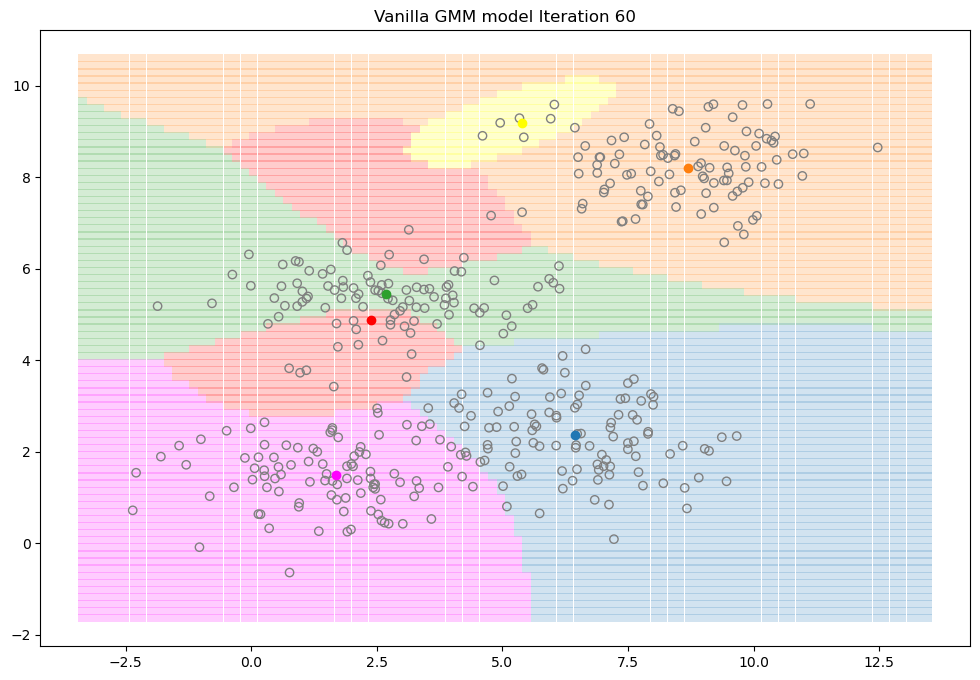

weights: [0.25224828 0.23467737 0.20099879 0.24922963 0.01426762 0.04844798],
 means:
 [[6.44077751 2.37475045]
 [8.70363836 8.20708739]
 [2.68278325 5.44869614]
 [1.69246916 1.49570838]
 [5.38427673 9.19487019]
 [2.38092311 4.88765515]],
 cov:
 [[[ 2.16745865 -0.29323138]
  [-0.29323138  0.70692775]]

 [[ 1.90229152  0.19262637]
  [ 0.19262637  0.50492558]]

 [[ 3.00367512 -0.11536066]
  [-0.11536066  0.20627041]]

 [[ 2.64769075  0.073059  ]
  [ 0.073059    0.50862417]]

 [[ 0.26921426  0.08644509]
  [ 0.08644509  0.05814522]]

 [[ 1.1787044   0.67649657]
  [ 0.67649657  1.10753493]]]


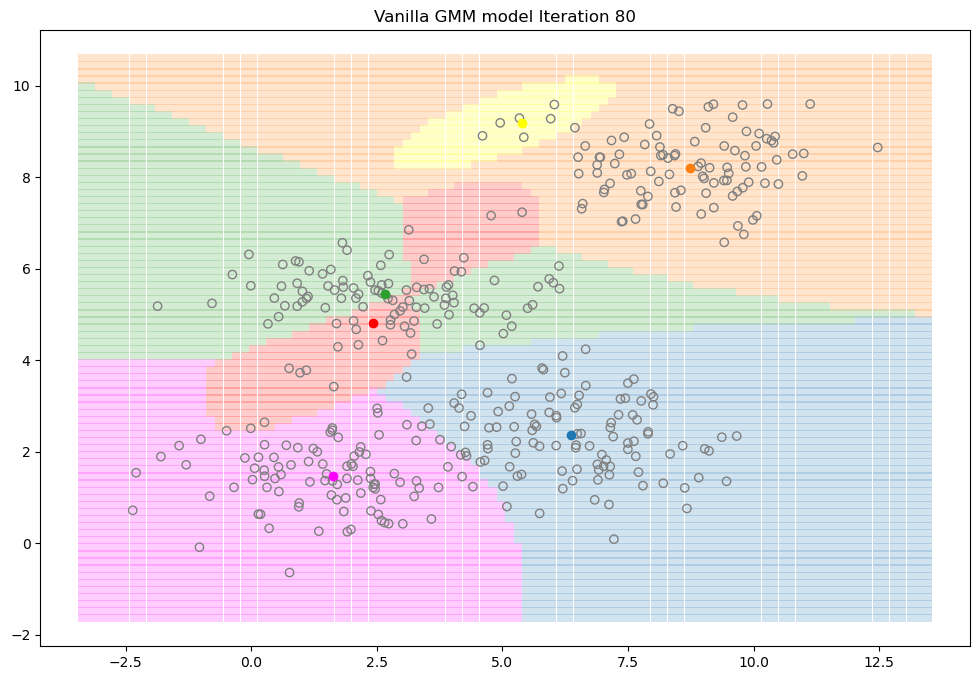

weights: [0.26032927 0.23304014 0.21228227 0.24186999 0.01433063 0.03807269],
 means:
 [[6.36275249 2.37490323]
 [8.72810844 8.21364258]
 [2.66208652 5.45042973]
 [1.63437773 1.47597762]
 [5.38479029 9.19393366]
 [2.43341064 4.80753099]],
 cov:
 [[[ 2.32458588 -0.30295184]
  [-0.30295184  0.70650004]]

 [[ 1.82803764  0.17043987]
  [ 0.17043987  0.50054883]]

 [[ 2.91252423 -0.1150583 ]
  [-0.1150583   0.23099945]]

 [[ 2.49797211  0.04751332]
  [ 0.04751332  0.49844736]]

 [[ 0.26910622  0.08611654]
  [ 0.08611654  0.05821651]]

 [[ 1.78517342  1.40900124]
  [ 1.40900124  1.3872271 ]]]


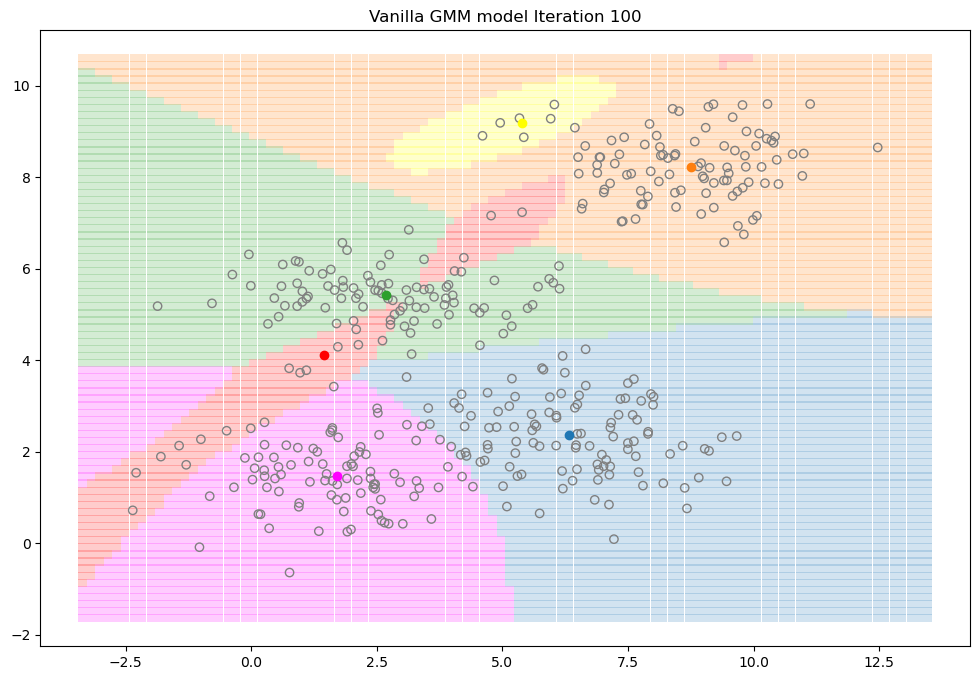

weights: [0.26594647 0.23062394 0.22338953 0.22630703 0.01443529 0.03927455],
 means:
 [[6.32213808 2.35767698]
 [8.75275074 8.2155947 ]
 [2.67778884 5.43553413]
 [1.71303902 1.46485518]
 [5.3869087  9.19282174]
 [1.4555381  4.10617346]],
 cov:
 [[[ 2.38092292 -0.27707638]
  [-0.27707638  0.70244211]]

 [[ 1.77909436  0.16122733]
  [ 0.16122733  0.49937488]]

 [[ 2.80589061 -0.11374297]
  [-0.11374297  0.24995371]]

 [[ 1.88645364  0.07396465]
  [ 0.07396465  0.52119153]]

 [[ 0.26950374  0.08554552]
  [ 0.08554552  0.05829775]]

 [[ 6.17115731  4.81799474]
  [ 4.81799474  3.84442762]]]


In [75]:
from scipy.stats import multivariate_normal


colors = ['tab:blue', 'tab:orange', 'tab:green', 'magenta', 'yellow', 'red', 'brown', 'grey']
eps=1e-8
for step in range(101):

  # visualize the learned clusters
  if step % 20 == 0:
    plt.figure(figsize=(12,int(8)))
    plt.title("Vanilla GMM model Iteration {}".format(step))
    axes = plt.gca()
    
    likelihood = []
    for j in range(k):
      likelihood.append(multivariate_normal.pdf(x=pos, mean=means[j], cov=cov[j]))
    likelihood = np.array(likelihood)
    predictions = np.argmax(likelihood, axis=0)
    
    for c in range(k):
      pred_ids = np.where(predictions == c)
      plt.scatter(pos[pred_ids[0],0], pos[pred_ids[0],1], color=colors[c], alpha=0.2, edgecolors='none', marker='s')
    
    plt.scatter(X[...,0], X[...,1], facecolors='none', edgecolors='grey')
    
    for j in range(k):
      plt.scatter(means[j][0], means[j][1], color=colors[j])

    #plt.savefig("img_{0:02d}".format(step), bbox_inches='tight')
    plt.show()
    print(f'weights: {weights},\n means:\n {means},\n cov:\n {cov}')

  likelihood = []
  # Expectation step
  for j in range(k):
    likelihood.append(multivariate_normal.pdf(x=X, mean=means[j], cov=cov[j]))
  likelihood = np.array(likelihood)
  assert likelihood.shape == (k, len(X))
    
  b = []
  # Maximization step 
  for j in range(k):
    # use the current values for the parameters to evaluate the posterior
    # probabilities of the data to have been generanted by each gaussian
    b.append((likelihood[j] * weights[j]) / (np.sum([likelihood[i] * weights[i] for i in range(k)], axis=0)+eps))

    # updage mean and variance
    means[j] = np.sum(b[j].reshape(len(X),1) * X, axis=0) / (np.sum(b[j]+eps))
    cov[j] = np.dot((b[j].reshape(len(X),1) * (X - means[j])).T, (X - means[j])) / (np.sum(b[j])+eps)

    # update the weights
    weights[j] = np.mean(b[j])
    
    assert cov.shape == (k, X.shape[1], X.shape[1])
    assert means.shape == (k, X.shape[1])

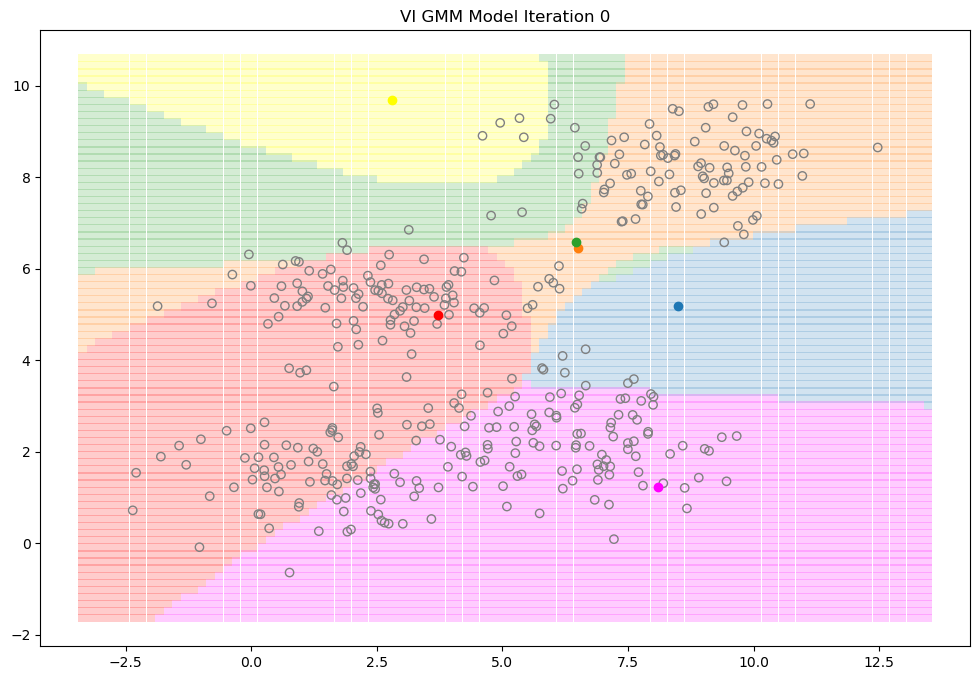

weights: [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667],
 means:
 [[8.50225376 5.18307425]
 [6.50756745 6.45989619]
 [6.45989619 6.578757  ]
 [8.09576532 1.21822417]
 [2.80724067 9.68912177]
 [3.72773771 4.99491678]],
 cov:
 [[[ 2.62304906 -0.38769366]
  [-0.38769366  0.76484311]]

 [[ 2.49468186  0.6049144 ]
  [ 0.6049144   0.90198392]]

 [[ 2.69691212 -0.53997528]
  [-0.53997528  0.99959095]]

 [[ 2.82537648  0.27230685]
  [ 0.27230685  0.89353577]]

 [[ 1.75651873 -0.9332685 ]
  [-0.9332685   0.97946575]]

 [[ 1.8486308   0.92739823]
  [ 0.92739823  1.09824145]]]


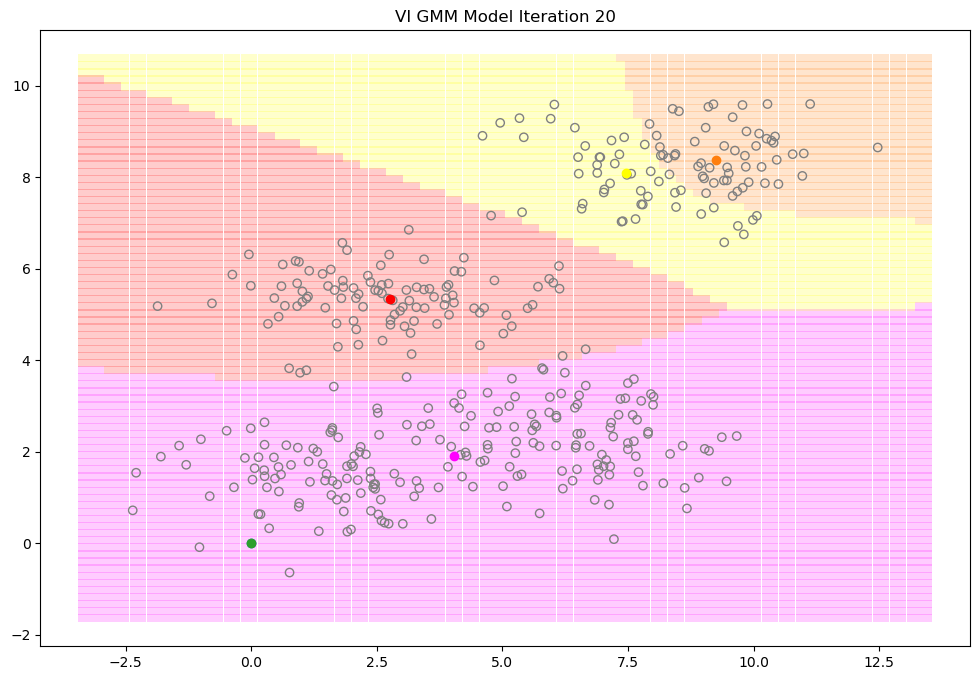

weights: [1.13178422e-10 2.25094991e-01 1.13178422e-10 3.03781855e-01
 1.57718410e-01 3.13404744e-01],
 means:
 [[0.         0.        ]
 [9.26006535 8.38722783]
 [0.         0.        ]
 [4.03534166 1.90641644]
 [7.46825032 8.10270392]
 [2.76001816 5.33381271]],
 cov:
 [[[ 1.00000000e-04  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e-04]]

 [[ 1.36425453e+00  1.75822319e-01]
  [ 1.75822319e-01  4.62808844e-01]]

 [[ 1.00000000e-04  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e-04]]

 [[ 8.13738092e+00  8.64304739e-01]
  [ 8.64304739e-01  7.33886173e-01]]

 [[ 1.88203369e+00 -6.02681961e-01]
  [-6.02681961e-01  5.62937153e-01]]

 [[ 2.90554137e+00 -8.61402797e-02]
  [-8.61402797e-02  4.26447475e-01]]]


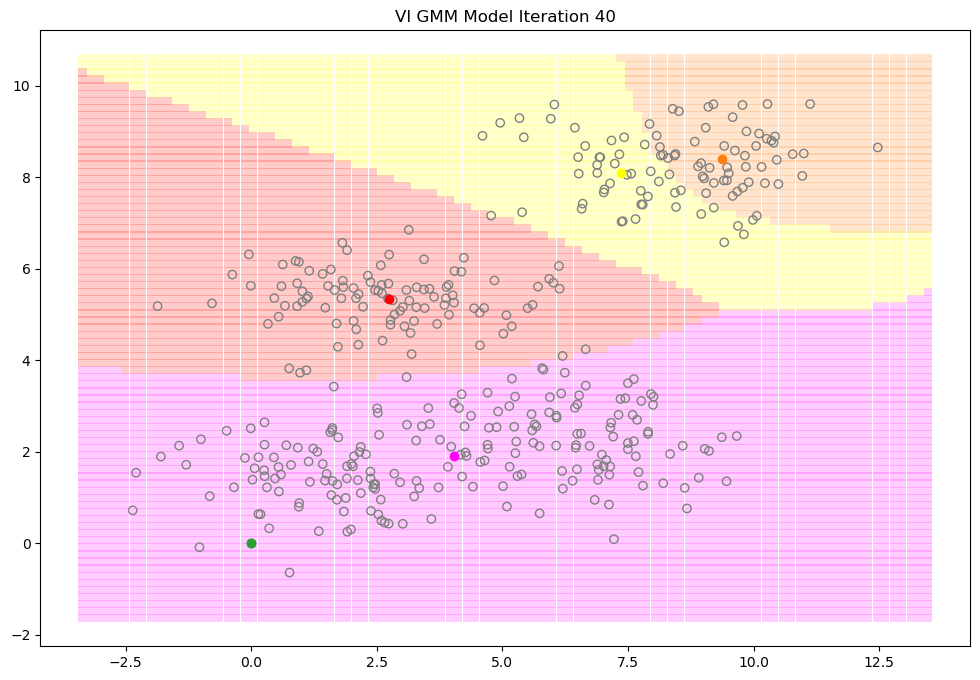

weights: [9.49549064e-11 2.31199693e-01 9.49549064e-11 2.96554915e-01
 1.63789938e-01 3.08455453e-01],
 means:
 [[0.         0.        ]
 [9.36663877 8.3973305 ]
 [0.         0.        ]
 [4.03570212 1.91093209]
 [7.35755515 8.09238398]
 [2.74898308 5.33823827]],
 cov:
 [[[ 1.00000000e-04  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e-04]]

 [[ 1.14917972e+00  1.00159812e-01]
  [ 1.00159812e-01  4.61771806e-01]]

 [[ 1.00000000e-04  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e-04]]

 [[ 8.12865317e+00  8.63248505e-01]
  [ 8.63248505e-01  7.40477002e-01]]

 [[ 1.71314002e+00 -5.19882840e-01]
  [-5.19882840e-01  5.56493809e-01]]

 [[ 2.88290980e+00 -8.42474696e-02]
  [-8.42474696e-02  4.09737797e-01]]]


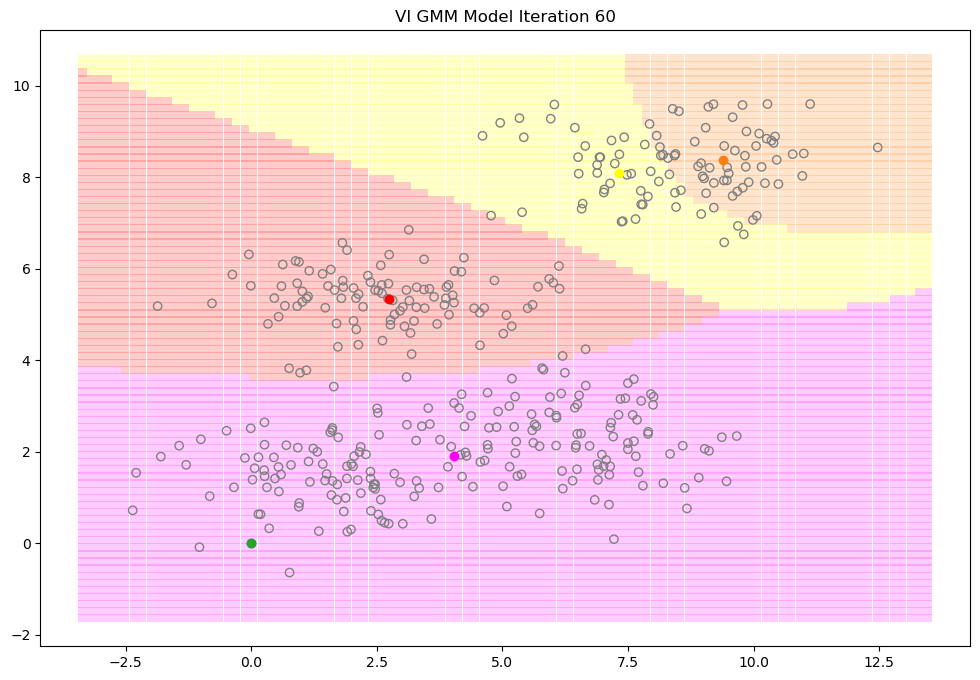

weights: [3.11204145e-11 2.31999367e-01 3.11204145e-11 2.95327301e-01
 1.65098455e-01 3.07574876e-01],
 means:
 [[0.         0.        ]
 [9.38821381 8.38922327]
 [0.         0.        ]
 [4.03538491 1.91120449]
 [7.33060906 8.10308794]
 [2.74767739 5.33755937]],
 cov:
 [[[ 1.00000000e-04  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e-04]]

 [[ 1.10998537e+00  9.34402815e-02]
  [ 9.34402815e-02  4.71523540e-01]]

 [[ 1.00000000e-04  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e-04]]

 [[ 8.12828049e+00  8.62538476e-01]
  [ 8.62538476e-01  7.40824655e-01]]

 [[ 1.66441795e+00 -4.87993587e-01]
  [-4.87993587e-01  5.50203382e-01]]

 [[ 2.88147582e+00 -8.73840767e-02]
  [-8.73840767e-02  4.06910738e-01]]]


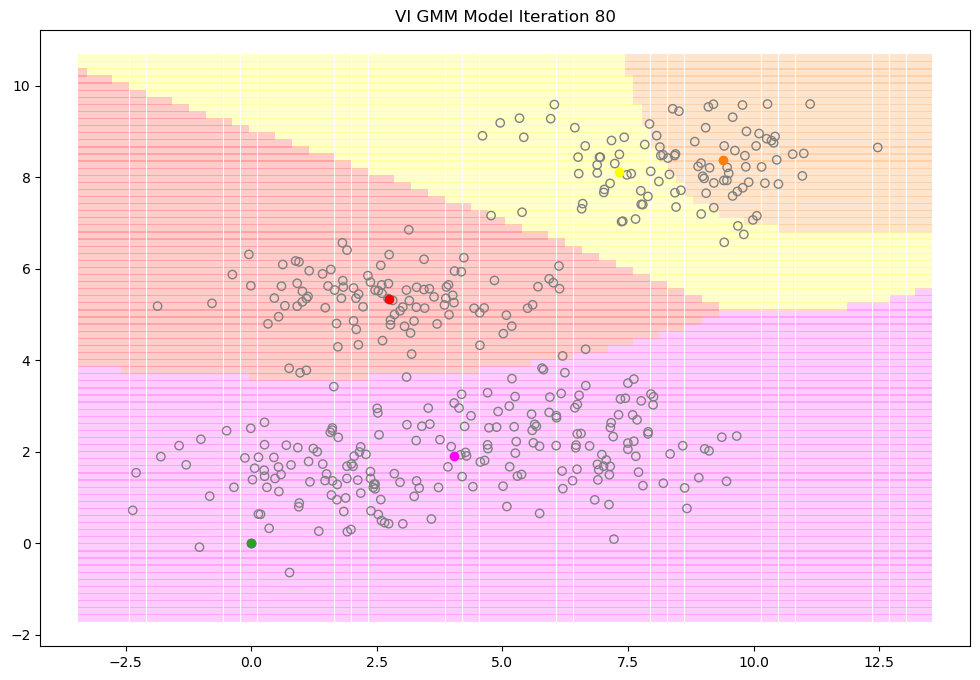

weights: [3.57818333e-11 2.32193083e-01 3.57818333e-11 2.95165043e-01
 1.65160796e-01 3.07481078e-01],
 means:
 [[0.         0.        ]
 [9.39149334 8.38656813]
 [0.         0.        ]
 [4.03530384 1.91128661]
 [7.32407561 8.10621744]
 [2.74732502 5.33740492]],
 cov:
 [[[ 1.00000000e-04  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e-04]]

 [[ 1.10356604e+00  9.29203499e-02]
  [ 9.29203499e-02  4.74169616e-01]]

 [[ 1.00000000e-04  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e-04]]

 [[ 8.12816389e+00  8.62352350e-01]
  [ 8.62352350e-01  7.40932238e-01]]

 [[ 1.65448774e+00 -4.80395957e-01]
  [-4.80395957e-01  5.48792568e-01]]

 [[ 2.88106640e+00 -8.81611801e-02]
  [-8.81611801e-02  4.06158329e-01]]]


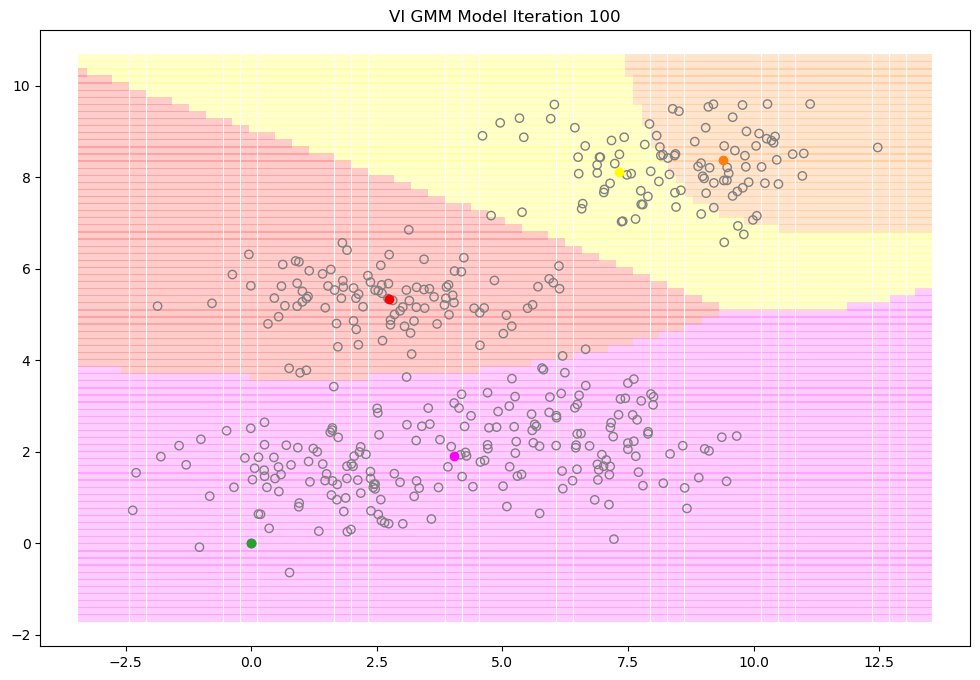

weights: [3.57306088e-11 2.32240414e-01 3.57306088e-11 2.95132962e-01
 1.65161887e-01 3.07464738e-01],
 means:
 [[0.         0.        ]
 [9.39217567 8.38590059]
 [0.         0.        ]
 [4.03528407 1.9113075 ]
 [7.32249954 8.10698907]
 [2.74723794 5.33736873]],
 cov:
 [[[ 1.00000000e-04  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e-04]]

 [[ 1.10218465e+00  9.28470182e-02]
  [ 9.28470182e-02  4.74811277e-01]]

 [[ 1.00000000e-04  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e-04]]

 [[ 8.12813397e+00  8.62306637e-01]
  [ 8.62306637e-01  7.40959782e-01]]

 [[ 1.65220708e+00 -4.78582925e-01]
  [-4.78582925e-01  5.48463200e-01]]

 [[ 2.88096356e+00 -8.83487528e-02]
  [-8.83487528e-02  4.05972940e-01]]]


In [73]:
# VI GMM model
def make_PSD(mat):
    # Make symmetric
    k = (mat + mat.T) / 2
    # Find the minimum eigenvalue
    min_eig = np.min(np.real(np.linalg.eigvals(mat)))
    # Add a small multiple of the identity matrix
    e = np.max([0, -min_eig + 1e-4])
    mat_PSD = k + e * np.eye(mat.shape[0])
    return mat_PSD

for step in range(101):

  # visualize the learned clusters
  if step % 20 == 0:
    plt.figure(figsize=(12,int(8)))
    plt.title("VI GMM Model Iteration {}".format(step))
    axes = plt.gca()
    
    likelihood = []
    for j in range(k):
      cov[j] = make_PSD(cov[j])
      likelihood.append(multivariate_normal.pdf(x=pos, mean=means[j], cov=cov[j]))
    likelihood = np.array(likelihood)
    predictions = np.argmax(likelihood, axis=0)
    
    for c in range(k):
      pred_ids = np.where(predictions == c)
      plt.scatter(pos[pred_ids[0],0], pos[pred_ids[0],1], color=colors[c], alpha=0.2, edgecolors='none', marker='s')
    
    plt.scatter(X[...,0], X[...,1], facecolors='none', edgecolors='grey')
    
    for j in range(k):
      plt.scatter(means[j][0], means[j][1], color=colors[j])

    #plt.savefig("img_{0:02d}".format(step), bbox_inches='tight')
    plt.show()
    print(f'weights: {weights},\n means:\n {means},\n cov:\n {cov}')

  likelihood = []
  # Expectation step
  for j in range(k):
    cov[j] = make_PSD(cov[j])
    likelihood.append(multivariate_normal.pdf(x=X, mean=means[j], cov=cov[j]))
  likelihood = np.array(likelihood)
  assert likelihood.shape == (k, len(X))
  # for multiple dimensions - not tested
  P = likelihood.T
  stat, C, weights = channel_capacity(k, len(x), P)
  # print('Optimal value of C = {:.4g}'.format(C))
  # print(f'Optimal variable weights[{j}] = {weights} \n') 
    
  b = []
  # Maximization step 
  for j in range(k):
    # use the current values for the parameters to evaluate the posterior
    # probabilities of the data to have been generanted by each gaussian
    if isinstance(likelihood, float):
      likelihood = np.array([likelihood])
    b.append((likelihood[j] * weights[j]) / (np.sum([likelihood[i] * weights[i] for i in range(k)], axis=0)+eps))

    # updage mean and variance
    means[j] = np.sum(b[j].reshape(len(X),1) * X, axis=0) / (np.sum(b[j]+eps))
    cov[j] = np.dot((b[j].reshape(len(X),1) * (X - means[j])).T, (X - means[j])) / (np.sum(b[j])+eps)

    # update the weights
    # weights[j] = np.mean(b[j])
    
    
    
    
    assert cov.shape == (k, X.shape[1], X.shape[1])
    assert means.shape == (k, X.shape[1])